In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-05-08 22:33:06,527 INFO: Initializing external client
2025-05-08 22:33:06,527 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-05-08 22:33:09,075 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1213682


In [5]:
# # Create a feature view if it doesn't already exist
# try:
#     feature_store.create_feature_view(
#         name=config.FEATURE_VIEW_NAME,
#         version=config.FEATURE_VIEW_VERSION,
#         query=feature_group.select_all(),
#     )
#     print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
# except Exception as e:
#     print(f"Error creating feature view: {e}")

# # Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [6]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly citibike rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


In [7]:
ts_data = ts_data.sort_values(["start_station_id", "start_hour"]).reset_index(drop=True)

In [8]:
ts_data.head()

,start_hour,start_station_id,rides
0,2024-01-01 00:00:00+00:00,5308.04,1
1,2024-01-01 01:00:00+00:00,5308.04,4
2,2024-01-01 02:00:00+00:00,5308.04,16
3,2024-01-01 03:00:00+00:00,5308.04,4
4,2024-01-01 04:00:00+00:00,5308.04,2


In [9]:
ts_data["start_hour"].min()

'2024-01-01 00:00:00+00:00'

In [10]:
ts_data["start_hour"].max()

'2025-05-09 02:00:00+00:00'

In [11]:
ts_data_copy = ts_data.copy()

In [12]:
import pandas as pd
ts_data["start_hour"] = pd.to_datetime(ts_data["start_hour"], errors="coerce")

In [13]:
ts_data["start_hour"] = ts_data["start_hour"].dt.tz_localize(None)
# ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize('US/Eastern', nonexistent = 'shift_forward', ambiguous = 'NaT')  # Remove timezone

In [14]:
ts_data["year_month"] = ts_data["start_hour"].dt.to_period("M")  # Year-Month format

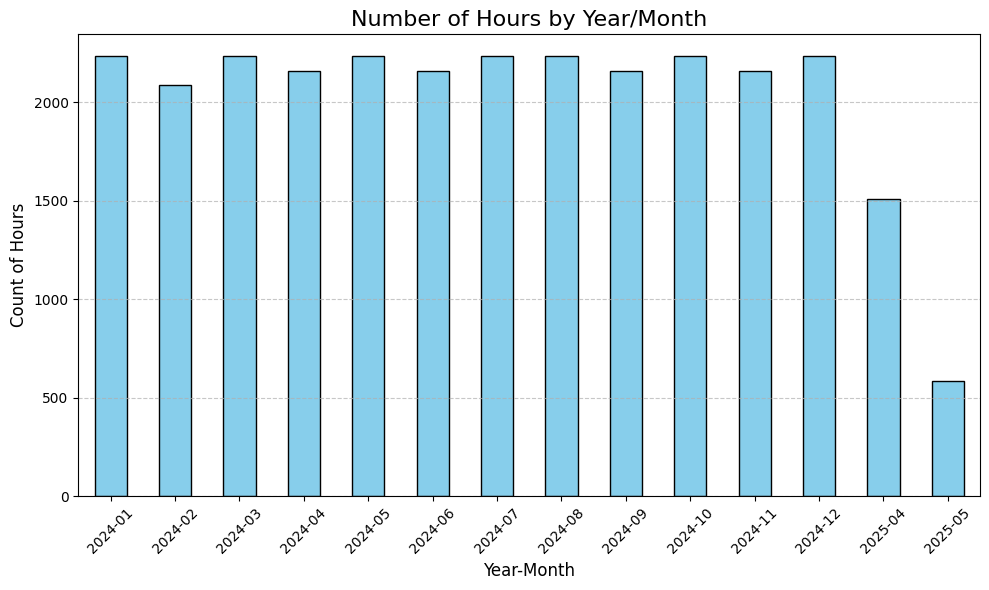

In [15]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [16]:
gte = ts_data["year_month"] >= pd.Period("2024-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2024-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [17]:
filtered_data.drop(columns=["year_month"], inplace=True)

In [18]:
filtered_data.shape

(26352, 3)

In [19]:
ts_data = filtered_data

In [20]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [21]:
features.sort_values(["start_station_id", "start_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,start_hour,start_station_id
0,1,4,16,4,2,0,0,0,1,3,...,4,6,6,11,5,3,0,1,2024-01-29 00:00:00,5308.04
1,0,1,0,0,0,0,0,3,3,11,...,7,4,13,10,15,13,6,5,2024-01-29 23:00:00,5308.04
2,3,7,3,0,0,0,0,1,2,3,...,8,4,9,15,16,13,8,6,2024-01-30 22:00:00,5308.04
3,6,2,1,2,0,0,0,0,0,1,...,4,4,6,6,7,22,21,16,2024-01-31 21:00:00,5308.04
4,11,5,2,3,2,1,0,0,0,1,...,10,9,10,7,13,14,12,19,2024-02-01 20:00:00,5308.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,4,10,9,9,12,8,6,5,1,3,...,0,0,4,4,5,7,9,10,2024-12-27 12:00:00,6230.02
1055,16,7,11,10,9,6,4,5,14,4,...,0,0,0,0,0,3,1,5,2024-12-28 11:00:00,6230.02
1056,2,5,11,4,9,10,9,10,4,4,...,0,1,0,0,1,1,0,2,2024-12-29 10:00:00,6230.02
1057,10,7,7,4,12,16,10,14,19,26,...,2,0,0,1,2,4,11,10,2024-12-30 09:00:00,6230.02


In [22]:
features[features["start_station_id"] == 5308.04]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,start_hour,start_station_id
0,1,4,16,4,2,0,0,0,1,3,...,4,6,6,11,5,3,0,1,2024-01-29 00:00:00,5308.04
1,0,1,0,0,0,0,0,3,3,11,...,7,4,13,10,15,13,6,5,2024-01-29 23:00:00,5308.04
2,3,7,3,0,0,0,0,1,2,3,...,8,4,9,15,16,13,8,6,2024-01-30 22:00:00,5308.04
3,6,2,1,2,0,0,0,0,0,1,...,4,4,6,6,7,22,21,16,2024-01-31 21:00:00,5308.04
4,11,5,2,3,2,1,0,0,0,1,...,10,9,10,7,13,14,12,19,2024-02-01 20:00:00,5308.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,4,14,10,12,14,11,8,7,9,0,...,0,1,0,1,5,2,3,6,2024-12-27 12:00:00,5308.04
349,9,11,10,15,12,17,11,11,9,7,...,1,1,0,0,1,1,5,1,2024-12-28 11:00:00,5308.04
350,17,15,4,14,18,17,22,20,19,10,...,0,0,0,0,0,0,0,2,2024-12-29 10:00:00,5308.04
351,13,5,7,4,13,8,10,12,23,17,...,0,0,0,0,0,0,4,6,2024-12-30 09:00:00,5308.04


In [23]:
features_copy = features.copy()

In [24]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(1059, 675)

In [25]:
features_targets["start_hour"] = features_targets["start_hour"].dt.tz_localize('US/Eastern', nonexistent = 'shift_forward', ambiguous = 'NaT')
# features_targets["pickup_hour"] = features_targets["pickup_hour"].dt.tz_localize(None)

In [26]:
# from datetime import datetime, timedelta  
# import pandas as pd  
# from src.data_utils import split_time_series_data  

# date_ref = datetime(2023, 9, 1, 0, 0, 0)

# # Define the cutoff date as 28 days before today  
# cutoff_date = pd.Timestamp(date_ref)  
# # # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# # cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # # Print the string representation of the cutoff date  
# # print(f"Cutoff date as string: {cutoff_date_str}")
# cutoff_date


from datetime import datetime
import pytz
from src.data_utils import split_time_series_data

est = pytz.timezone("US/Eastern")

# Convert the cutoff date to EST timezone
cutoff_date = est.localize(datetime(2024, 10, 1, 5, 0, 0))

X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(771, 674)
(771,)
(288, 674)
(288,)


In [29]:
from src.pipeline_utils import get_pca_pipeline


# Train and evaluate the LightGBM model
model = get_pca_pipeline()


In [30]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 771, number of used features: 10
[LightGBM] [Info] Start training from score 9.080415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Pipeline(steps=[('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('pcatransformer', PCATransformer()),
                ('lgbmregressor', LGBMRegressor())])

In [31]:
from sklearn.metrics import mean_absolute_error
predictions = model.predict(X_test)

In [32]:
predictions

array([ 1.89512224e+01,  9.10490457e+00, -2.95125646e+00,  2.50783875e+00,
        4.51132496e+00,  6.03688903e+00,  7.11846013e+00,  6.45617809e+00,
        1.07625135e+01,  1.58967717e+01,  2.51548128e+01,  2.30131738e+01,
        3.04272860e+01,  2.89174252e+01,  2.17809523e+01,  2.06006156e+01,
        1.58510347e+01,  1.74844750e+01,  2.23149470e+01,  2.33533094e+01,
        1.81291973e+01,  1.36976886e+01,  1.75648385e+01,  1.96417561e+01,
        1.25623887e+01,  1.05972844e-01,  7.48485213e-03,  5.27397865e+00,
        5.24260088e+00,  2.02124772e-01,  1.32311377e+00,  7.31697643e+00,
        7.26225853e+00,  1.85964065e+01,  1.45944732e+01,  2.01209082e+01,
        2.80844694e+01,  2.39185154e+01,  2.29346401e+01,  2.33566967e+01,
        2.43309443e+01,  2.95807515e+01,  2.87897681e+01,  1.90480498e+01,
        1.68359993e+01,  1.72202049e+01,  2.50837729e+01,  1.68349407e+01,
        4.39704898e+00,  6.02007799e-01,  1.99626122e+00,  2.20543423e+00,
       -6.93266508e-01,  

In [33]:
test_mae = mean_absolute_error(y_test, predictions)
print(f"{test_mae:.4f}")

5.3191


In [45]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

# Custom transformer to add temporal features
class TemporalFeatureEngineer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_["hour"] = X_["start_hour"].dt.hour
        X_["day_of_week"] = X_["start_hour"].dt.dayofweek

        return X_.drop(columns=["start_hour", "start_station_id"])

        
# Custom transformer for feature selection based on feature importances
class FeatureImportanceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, model, top_n=10):
        """
        Selects the top N features based on the feature importances from the provided model.
        
        Parameters:
        ----------
        model : sklearn model
            The trained model used to obtain feature importances.
        top_n : int, optional
            The number of top features to select based on feature importances (default is 10).
        """
        self.model = model
        self.top_n = top_n
        self.selected_features = []

    def fit(self, X, y=None):
        # Fit the model to get feature importances
        self.model.fit(X, y)
        # Get feature importances and sort them in descending order
        importances = self.model.feature_importances_
        # Get the indices of the top N features
        indices = np.argsort(importances)[::-1][:self.top_n]
        self.selected_features = indices
        return self

    def transform(self, X):
        # Return only the selected top N features
        return X.iloc[:, self.selected_features]

# Function to return the pipeline with feature importance-based selection and LGBMRegressor
def get_pipeline_feature_importance(**hyper_params):
    """
    Returns a pipeline with temporal feature engineering, feature importance-based feature selection, and LGBMRegressor.

    Parameters:
    ----------
    **hyper_params : dict
        Optional parameters to pass to the LGBMRegressor.

    Returns:
    -------
    pipeline : sklearn.pipeline.Pipeline
        A pipeline with temporal feature engineering, feature selection, and LGBMRegressor.
    """
    # Initialize the LGBMRegressor
    lgb_model = lgb.LGBMRegressor(**hyper_params)
    
    pipeline = make_pipeline(
        TemporalFeatureEngineer(),             # Add temporal features
        FeatureImportanceSelector(model=lgb_model, top_n=10),  # Apply feature importance-based selection
        lgb_model                             # Train the LGBM model on the reduced feature set
    )
    return pipeline

In [54]:
from src.pipeline_utils import get_pipeline_feature_importance

# Train and evaluate the LightGBM model
model = get_pipeline_feature_importance()


In [55]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25224
[LightGBM] [Info] Number of data points in the train set: 771, number of used features: 674
[LightGBM] [Info] Start training from score 9.080415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Pipeline(steps=[('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('featureimportanceselector',
                 FeatureImportanceSelector(model=LGBMRegressor())),
                ('lgbmregressor', LGBMRegressor())])

In [56]:
from sklearn.metrics import mean_absolute_error
predictions = model.predict(X_test)

In [57]:
test_mae = mean_absolute_error(y_test, predictions)
print(f"{test_mae:.4f}")

3.5710


In [58]:
import joblib  

# Save the pipeline  
joblib.dump(model, config.MODELS_DIR / "lgb_model.pkl")

['C:\\Users\\sahit\\ESDS\\github\\sp25_citibike_nyc\\models\\lgb_model.pkl']

In [59]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [60]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="citibike_demand_predictor",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor with Feature Importance",
    input_example=features.sample(),
    model_schema=model_schema
    # include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('C:\\Users\\sahit\\ESDS\\github\\sp25_citibike_nyc\\models\\lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/268533 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2137 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/51324 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1213682/models/citibike_demand_predictor/1


Model(name: 'citibike_demand_predictor', version: 1)

In [66]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-05-09 01:17:15,455 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-09 01:17:15,472 INFO: Initializing external client
2025-05-09 01:17:15,472 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-05-09 01:17:16,880 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1213682

In [67]:
from src.inference import get_model_predictions

In [68]:
# preds = get_model_predictions(model, features_copy)
preds = get_model_predictions(model, X_test)

In [69]:
preds

,start_station_id,predicted_demand
0,5308.04,12.0
1,5308.04,6.0
2,5308.04,0.0
3,5308.04,0.0
4,5308.04,6.0
...,...,...
283,6230.02,10.0
284,6230.02,8.0
285,6230.02,2.0
286,6230.02,9.0


In [70]:
test_mae = mean_absolute_error(y_test, preds["predicted_demand"])
print(f"{test_mae:.4f}")

3.5382
